In [ ]:
!pip install pysentimiento

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.w

In [ ]:
import os
import ast
import warnings
import matplotlib
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import statsmodels.api as sm
from google.colab import drive
import matplotlib.pyplot as plt
from collections import Counter
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from pysentimiento import create_analyzer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
drive.mount('/content/drive', force_remount=True)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from pysentimiento.preprocessing import preprocess_tweet
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV

Mounted at /content/drive


In [ ]:
dataset_path = os.path.join(os.getcwd(), "drive/My Drive/BDS_proj/data")
raw = os.path.join(dataset_path, "raw.csv")
trend = os.path.join(dataset_path, "google_trend.csv")

In [ ]:
df = pd.read_csv(raw)

In [ ]:
dataset_path = os.path.join(os.getcwd(), "drive/My Drive/BDS_proj/data")
raw = os.path.join(dataset_path, "raw.csv")
trend = os.path.join(dataset_path, "google_trend.csv")
df = pd.read_csv(raw)
df = df[["overview", "budget", "revenue", "runtime", "year", "release_date", "genres", "vote_average", "popularity", "core_actor", "actor_avg_age", "production_companies", "month"]]
df["budget"] = df["budget"].astype(int)
df["runtime"] = df["runtime"].astype(int)
df = df[df["core_actor"].notna()]
df = df[df["actor_avg_age"] > 10]
df.dropna(inplace=True)
df["profitable"] = df["revenue"] / df["budget"]
df["profitable"] = df["profitable"] > 1
df["profitable"] = df["profitable"].astype(int)
df = df.drop(["revenue"], axis=1)

all_genres = set()
genres_list = df['genres'].apply(ast.literal_eval)
for genre_list in genres_list:
    for genre in genre_list:
        all_genres.add(genre)
all_genres = list(all_genres)
df[all_genres] = 0
for i, genre_list in enumerate(genres_list):
    df.loc[i, genre_list] = 1
df = df.drop(["genres"], axis=1)
df = df.dropna()
company_freq = {}
df['production_companies'] = df['production_companies'].apply(ast.literal_eval)
for company_list in df["production_companies"]:
    for company_id in company_list:
        if company_id not in company_freq:
            company_freq[company_id] = 0
        company_freq[company_id] += 1
company_freq = {x:y for x, y in company_freq.items() if y > 6}
df["company_freq"] = 0
for i, company_list in enumerate(df["production_companies"]):
    for id in company_list:
        if id in company_freq:
            df.loc[i, ["company_freq"]] = 1
            break
df = df.drop(["production_companies"], axis=1)
df = df.dropna()
df['release_date'] = df['release_date'].astype('datetime64[ns]')

trend = pd.read_csv(trend)
trend["begin_date"] = pd.to_datetime(trend["begin_date"])
trend["end_date"] = trend["begin_date"] + pd.DateOffset(days=7)
trend["movie_count"] = 0
trend["movie_gain"] = 0

df["google_trend"] = 0
for i, date in enumerate(df["release_date"]):
    interest = trend[(trend["begin_date"] <= date) & (date <= trend["end_date"])]["interest"].iloc[0]
    df.loc[i, ["google_trend"]] = interest

    trend.loc[(trend["begin_date"] <= date) & (date <= trend["end_date"]), ["movie_count"]] += 1
    if df.loc[i, ["profitable"]].iloc[0] == 1:
        trend.loc[(trend["begin_date"] <= date) & (date <= trend["end_date"]), ["movie_gain"]] += 1
df = df.drop(["release_date"], axis=1)
trend['cumulative_gain'] = trend['movie_gain'].cumsum()
trend['cumulative_count'] = trend['movie_count'].cumsum()
df = df.reset_index(drop=True).dropna()
emotion_analyzer = create_analyzer(task="emotion", lang="en")
df["emotion"] = df.overview.apply(lambda x:emotion_analyzer.predict(x).probas)
for i in df.emotion[0].keys():
  df[i] = df.emotion.apply(lambda x: x[i] if pd.notnull(x) else x)
df.drop(columns = ['overview', 'emotion'],inplace=True)


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
X = df.drop(columns=["profitable"])
y = df.profitable
x = X.values
min_max_scaler = MinMaxScaler()
X_scaled = pd.DataFrame(min_max_scaler.fit_transform(x), columns = X.columns)
selector = SelectKBest(mutual_info_classif, k=11)
selector.fit(X_scaled, y)
cols_idxs = selector.get_support(indices=True)
X_new = X_scaled.iloc[:,cols_idxs]
X_new.dtypes

budget          float64
year            float64
vote_average    float64
popularity      float64
Music           float64
Documentary     float64
Crime           float64
Action          float64
google_trend    float64
others          float64
disgust         float64
dtype: object

In [ ]:
X_new

,budget,year,vote_average,popularity,Music,Documentary,Crime,Action,google_trend,others,disgust
0,0.156063,1.0,0.723404,1.000000,0.0,0.0,0.0,1.0,0.73,0.845544,0.001097
1,0.271343,1.0,0.658085,0.466607,0.0,0.0,0.0,0.0,0.73,0.106399,0.000065
2,0.053834,1.0,0.632553,0.436385,0.0,0.0,0.0,0.0,0.82,0.981751,0.004918
3,0.075585,1.0,0.789149,0.414648,0.0,0.0,0.0,0.0,0.73,0.991408,0.004729
4,0.445351,1.0,0.572979,0.316938,0.0,0.0,0.0,1.0,0.82,0.994881,0.003805
...,...,...,...,...,...,...,...,...,...,...,...
400,0.038173,0.0,0.638298,0.021592,0.0,0.0,0.0,0.0,0.00,0.995731,0.001896
401,0.019032,0.0,0.491277,0.019652,0.0,0.0,0.0,0.0,0.00,0.938383,0.017197
402,0.003806,0.0,0.433830,0.014985,0.0,0.0,0.0,0.0,0.00,0.000000,0.000756
403,0.053834,0.0,0.799574,0.012588,0.0,0.0,0.0,0.0,0.00,0.994795,0.004547


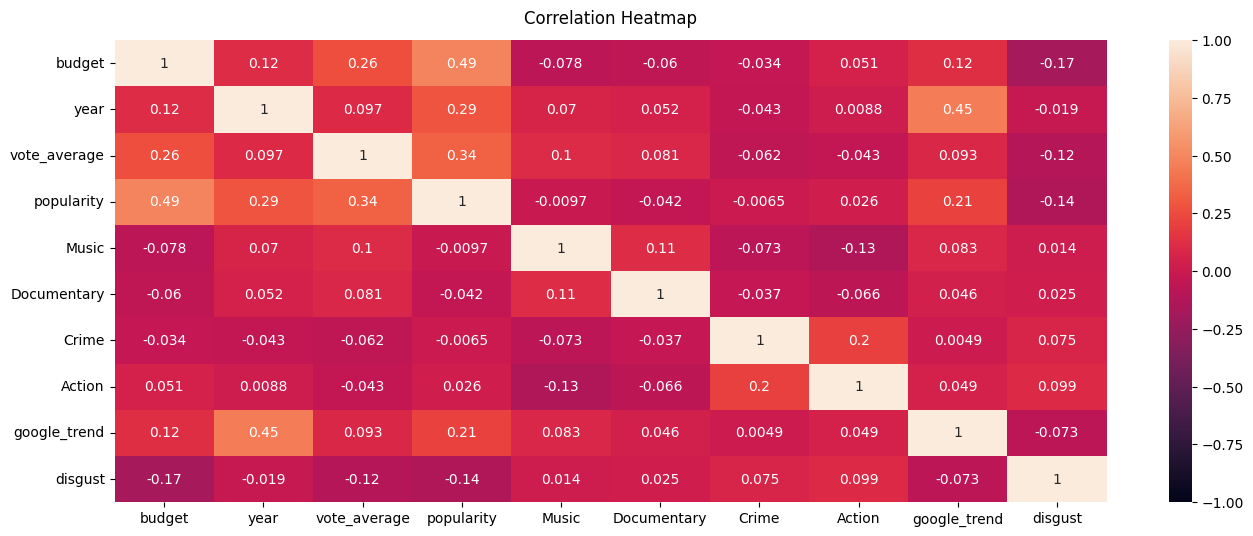

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd

cor = X_new.drop(columns=['others'])
cor.profitable = y

matrix = cor.corr()
plt.figure(figsize=(16, 6))

#plotting correlation matrix
heatmap = sns.heatmap(matrix, annot=True, vmin=-1, vmax=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
def compare_scores(scores_dict):
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df



X = X_new
(
  X_train,
  X_test,
  y_train,
  y_test,
) = train_test_split(X, y, test_size=0.3)
classifiers = {'KNN': KNeighborsClassifier(),
              'Naive Bayes': GaussianNB(),
              'Decision Tree': DecisionTreeClassifier(),
              'Neural Network': MLPClassifier(),
              'Support Vector': SVC(),
              'Stochastic Gradient Descent': SGDClassifier(),
              'Random Forest': RandomForestClassifier(),
              'Gradient Boosting': GradientBoostingClassifier(),
              'Bagging': BaggingClassifier(KNeighborsClassifier())}
scores_train = {}
for classifier in classifiers:
    scores_train[classifier] = cross_validate(classifiers[classifier],
            X_train, y_train, cv=10, scoring=[
        'accuracy',
        'precision',
        'recall',
        'f1',
        'f1_macro',
        'f1_micro',
        ])
compare_scores(scores_train)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
KNN,0.005779,0.025056,0.565640,0.592879,0.625417,0.603812,0.555062,0.565640
Naive Bayes,0.005004,0.018533,0.551232,0.938333,0.184583,0.297143,0.482921,0.551232
Decision Tree,0.007411,0.020252,0.713670,0.732522,0.749583,0.737074,0.708513,0.713670
Neural Network,1.230853,0.056002,0.689409,0.701884,0.737500,0.712871,0.682460,0.689409
Support Vector,0.010237,0.021561,0.639655,0.663588,0.684167,0.668143,0.628663,0.639655
Stochastic Gradient Descent,0.007338,0.018423,0.643350,0.680744,0.775833,0.684926,0.603528,0.643350
Random Forest,0.392745,0.032290,0.752463,0.767267,0.782500,0.772842,0.749495,0.752463
Gradient Boosting,0.297418,0.028566,0.703325,0.726303,0.723750,0.723271,0.700484,0.703325
Bagging,0.059232,0.049698,0.586576,0.612765,0.617917,0.610965,0.580488,0.586576


In [ ]:
clf1 = RandomForestClassifier()

param1 = {}
param1['classifier__n_estimators'] = [5, 10, 50, 100]
param1['classifier__max_depth'] = [None, 5, 10, 15, 20]
param1['classifier__max_features'] = [3, 5 ,7]
param1['classifier__min_samples_leaf'] = [7, 3, 5]
param1['classifier__min_samples_split'] = [7, 3, 5]
param1['classifier'] = [clf1]
pipeline = Pipeline([('classifier', clf1)])
params = [param1]
gs = GridSearchCV(pipeline, params, scoring='f1').fit(X_train,
        y_train)
print('Best parameter set: ' + str(gs.best_params_))
print('Best f1: %.3f' % gs.best_score_)

Best parameter set: {'classifier': RandomForestClassifier(max_depth=15, max_features=7, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=50), 'classifier__max_depth': 15, 'classifier__max_features': 7, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Best f1: 0.809


In [ ]:
data = pd.read_csv(bin_data)[['profitable','google_trend']]
test='ssr_chi2test'
variables = data.columns
verbose = False
df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
for c in df.columns:
    for r in df.index:
        test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values)
        df.loc[r, c] = min_p_value
df.columns = [var + '_x' for var in variables]
df.index = [var + '_y' for var in variables]

In [ ]:
df

,profitable_x,google_trend_x
profitable_y,1.0000,0.0022
google_trend_y,0.1681,1.0000
